In [1]:
#Import the libraries
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.utils import resample
from sklearn.manifold import TSNE
from sklearn import decomposition
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
rand_state=123
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("green")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [3]:
#This function is used to plot the ROC curve on both train and test.
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_roc_curve(classifier, X_train, y_train, X_test, y_test):
    from sklearn.metrics import roc_curve, auc
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    '''TEST DATA ROC CURVE'''
    #Use probability scores to compute the ROC Curve
    class_probabilities = classifier.predict_proba(X_test)
    y_probs = class_probabilities[:,1]
    fpr["Test"], tpr["Test"], threshold = roc_curve(y_test, y_probs)
    roc_auc["Test"] = auc(fpr["Test"], tpr["Test"])
    
    '''TRAIN DATA ROC CURVE'''
    #Use probability scores to compute the ROC Curve
    class_probabilities = classifier.predict_proba(X_train)
    y_probs = class_probabilities[:,1]
    fpr["Train"], tpr["Train"], threshold = roc_curve(y_train, y_probs)
    roc_auc["Train"] = auc(fpr["Train"], tpr["Train"])
    
    plt.figure(figsize=(10,7))
    linewidth = 2
    plt.plot(fpr["Test"], tpr["Test"], color='green', lw=linewidth, label='ROC curve Test Data (area = %0.2f)' % roc_auc["Test"])
    plt.plot(fpr["Train"], tpr["Train"], color='red', lw=linewidth, label='ROC curve Train Data (area = %0.2f)' % roc_auc["Train"])
    plt.plot([0, 1], [0, 1], color='navy', lw=linewidth, linestyle='--', label='Baseline ROC curve (area = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
def model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels):
    
    #To store results at various phases during training as well as cross validation stages
    results = dict()
    model = rsearch_cv.best_estimator_
    
    #Time at which model starts training 
    train_start_time = dt.now()
    print('Training the model...')
    model.fit(X_train, y_train)
    print('Training completed... \n \n')
    train_end_time = dt.now()
    results['Training_Time'] =  train_end_time - train_start_time
    print('Training Time (HH:MM:SS.ms) -- {}\n\n'.format(results['Training_Time']))
    
    
    #Predict the test data
    print('Predicting test data...')
    test_start_time = dt.now()
    y_pred = model.predict(X_test)
    test_end_time = dt.now()
    print('Predicting test data completed... \n \n')
    results['Testing_Time'] = test_end_time - test_start_time
    print('Testing Time(HH:MM:SS:ms) -- {}\n\n'.format(results['Testing_Time']))
    results['Predicted'] = y_pred
   

    #Compute the F1 score 
    f1_score = metrics.f1_score(y_true=y_test, y_pred=y_pred, average='micro') #F1 = 2 * (precision * recall) / (precision + recall)
    
    #Store F1 Score in results
    results['F1_Score'] = f1_score
    print('---------------------')
    print('|      F1 Score      |')
    print('---------------------')
    print('\n    {}\n\n'.format(f1_score))      
    

    #Calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
        
    #Store the accuracy in results
    results['Accuracy'] = accuracy
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))
    
    #Calculate overall recall_score of the model
    recall = metrics.recall_score(y_true=y_test, y_pred=y_pred)
        
    #Store the accuracy in results
    results['Recall'] = recall
    print('---------------------')
    print('|      Recall        |')
    print('---------------------')
    print('\n    {}\n\n'.format(recall))
    
    #Calculate overall roc-auc of the model
    #Calibrate the model
    sig_clf = CalibratedClassifierCV(model, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    class_probabilities = sig_clf.predict_proba(X_test)
    y_probs = class_probabilities[:,1]
    roc_auc = metrics.roc_auc_score(y_true=y_test, y_score=y_probs)
        
    #Store the ROC-AUC in results
    results['ROC-AUC'] = roc_auc
    print('---------------------')
    print('|      ROC AUC       |')
    print('---------------------')
    print('\n    {}\n\n'.format(roc_auc))   
                   
    #Display the classification report having individual class recalls and precision values.
    print('-------------------------')
    print('| Classifiction Report  |')
    print('-------------------------')
    classification_report = metrics.classification_report(y_test, y_pred)
    
    #Store report in results
    results['Classification_Report'] = classification_report
    print(classification_report)
    
    #Add the trained  model to the results
    results['Model'] = model
    
    #Plot the confusion matrix curve
    plot_confusion_matrix(y_test, y_pred)
    
    return results, model

In [5]:
def print_grid_search_attributes(model):
    #Estimator that gave highest score among all the estimators formed in GridSearch
    print('--------------------------')
    print('|      Best Estimator     |')
    print('--------------------------')
    print('\n\t{}\n'.format(model.best_estimator_))

    #Parameters that gave best results while performing grid search
    print('--------------------------')
    print('|     Best parameters     |')
    print('--------------------------')
    print('\tParameters of best estimator : \n\n\t{}\n'.format(model.best_params_))

    #Number of cross validation splits
    print('---------------------------------')
    print('|   No of CrossValidation sets   |')
    print('--------------------------------')
    print('\n\tTotal numbre of cross validation sets: {}\n'.format(model.n_splits_))

    #Average cross validated score of the best estimator, from the Grid Search 
    print('--------------------------')
    print('|        Best Score       |')
    print('--------------------------')
    print('\n\tAverage Cross Validate scores of best estimator : \n\n\t{}\n'.format(model.best_score_))

In [27]:
# Loading the saved file for appetency
df_train_upselling=pd.read_csv('df_train_upselling.csv')

In [28]:
df_train_upselling.upselling.value_counts()

0    46318
1     3682
Name: upselling, dtype: int64

### 1. No Sampling(Class_Weight='balanced')

In [29]:
X=df_train_upselling.drop("upselling", axis=1)
y=df_train_upselling['upselling']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=rand_state)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (40000, 77)
Number transactions y_train dataset:  (40000,)
Number transactions X_test dataset:  (10000, 77)
Number transactions y_test dataset:  (10000,)


### Visualizaing the data using t_SNE and PCA

In [30]:
def tsne(dataset, labels, perplexity):
    labels=labels.apply(lambda x: 'upselling' if x==1 else 'No upselling')    
    #Starting TSNE dataset transform
    model = TSNE(n_components=2, init='random', random_state=rand_state, verbose=1, angle=0.5, method='barnes_hut', perplexity=perplexity, n_iter=1000)
    tsne_data = model.fit_transform(dataset)

    #Creating a new data frame which help us in ploting the result data
    tsne_data = np.vstack((tsne_data.T, labels)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Label Type"))
    
    #Info
    print("\nT-SNE Plot for perplexity = {}".format(perplexity))
    
    # Ploting the result of tsne
    sns.FacetGrid(tsne_df, hue="Label Type", height=6).map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
    plt.show()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 40000 samples in 0.686s...
[t-SNE] Computed neighbors for 40000 samples in 42.956s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40000
[t-SNE] Computed conditional probabilities for sample 2000 / 40000
[t-SNE] Computed conditional probabilities for sample 3000 / 40000
[t-SNE] Computed conditional probabilities for sample 4000 / 40000
[t-SNE] Computed conditional probabilities for sample 5000 / 40000
[t-SNE] Computed conditional probabilities for sample 6000 / 40000
[t-SNE] Computed conditional probabilities for sample 7000 / 40000
[t-SNE] Computed conditional probabilities for sample 8000 / 40000
[t-SNE] Computed conditional probabilities for sample 9000 / 40000
[t-SNE] Computed conditional probabilities for sample 10000 / 40000
[t-SNE] Computed conditional probabilities for sample 11000 / 40000
[t-SNE] Computed conditional probabilities for sample 12000 / 40000
[t-SNE] Computed conditional probabilities for s

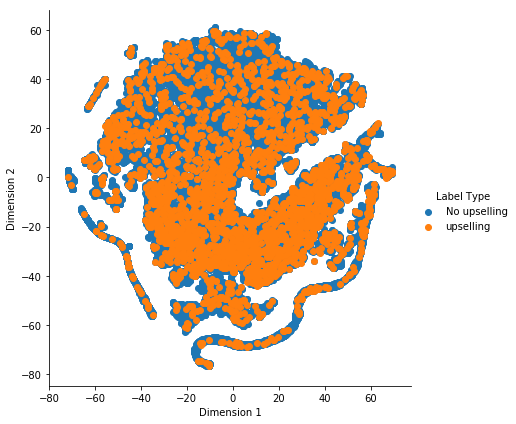

Time taken to complete random search:  0:17:51.266726


In [31]:
st=dt.now()
tsne(X_train, y_train, 50)
print("Time taken to complete random search: ",dt.now()-st)

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 40000 samples in 0.438s...
[t-SNE] Computed neighbors for 40000 samples in 75.647s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40000
[t-SNE] Computed conditional probabilities for sample 2000 / 40000
[t-SNE] Computed conditional probabilities for sample 3000 / 40000
[t-SNE] Computed conditional probabilities for sample 4000 / 40000
[t-SNE] Computed conditional probabilities for sample 5000 / 40000
[t-SNE] Computed conditional probabilities for sample 6000 / 40000
[t-SNE] Computed conditional probabilities for sample 7000 / 40000
[t-SNE] Computed conditional probabilities for sample 8000 / 40000
[t-SNE] Computed conditional probabilities for sample 9000 / 40000
[t-SNE] Computed conditional probabilities for sample 10000 / 40000
[t-SNE] Computed conditional probabilities for sample 11000 / 40000
[t-SNE] Computed conditional probabilities for sample 12000 / 40000
[t-SNE] Computed conditional probabilities for s

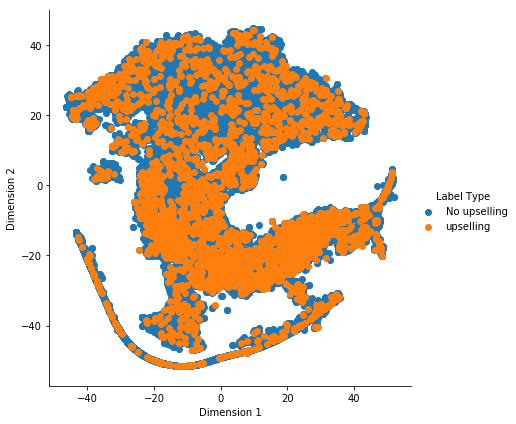

Time taken to complete random search:  0:29:25.773225


In [32]:
st=dt.now()
tsne(X_train, y_train, 200)
print("Time taken to complete random search: ",dt.now()-st)

Shape of the Data Matrix before reducing dimension:  (40000, 77)
Shape of the Data Matrix after reducing dimension:  (40000, 2)


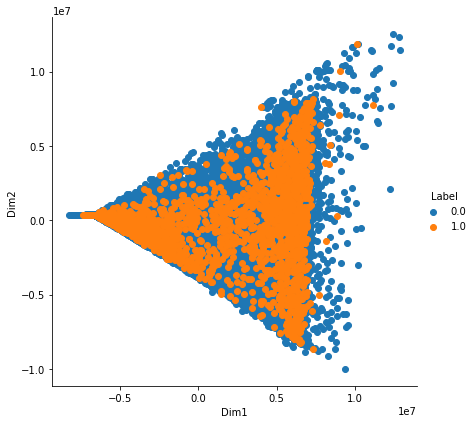

In [33]:
#Initialize the PCA
from sklearn import decomposition
pca = decomposition.PCA()

#Configure the parameteres: Number of components = 2
pca.n_components = 2
pca_data = pca.fit_transform(X_train)

#pca_data will contain the 2-D projections of X_train
print("Shape of the Data Matrix before reducing dimension: ",X_train.shape)
print("Shape of the Data Matrix after reducing dimension: ",pca_data.shape)

#Attaching the label for each 2D data point. 
pca_data = np.vstack((pca_data.T, y_train)).T

#Creating a new dataframe which help us in ploting the result data. The new dataframe contains the reduced dimension of X_train along with the class label.
pca_df = pd.DataFrame(data=pca_data, columns=("Dim1", "Dim2", "Label"))
sns.FacetGrid(pca_df, hue="Label", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

#### 1.1 Decision Tree

In [34]:
st=dt.now()
params = {'max_depth': np.arange(2,30,2),
                    'criterion': ['gini','entropy'],
                    'min_samples_split': np.arange(0.1,1.0,0.1),
                    'min_samples_leaf' : np.arange(1,10,1),
                    'min_weight_fraction_leaf' : [0.0,0.1,0.2,0.3,0.4]} 

model = DecisionTreeClassifier(random_state=rand_state,class_weight='balanced')
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=params, 
                                cv=3, scoring='roc_auc',
                                verbose=1,
                                n_jobs=-1,
                                random_state=rand_state)

rsearch_cv.fit(X_train, y_train)
print("Time taken to complete random search: ",dt.now()-st)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   17.4s finished


Time taken to complete random search:  0:00:18.951715


In [35]:
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=22, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=0.5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'min_weight_fraction_leaf': 0.0, 'min_samples_split': 0.5, 'min_samples_leaf': 2, 'max_depth': 22, 'criterion': 'entropy'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 3

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores 

Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:00.953767


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.029084


---------------------
|      F1 Score      |
---------------------

    0.9362


---------------------
|      Accuracy      |
---------------------

    0.9362


---------------------
|      Recall        |
---------------------

    0.48233695652173914


---------------------
|      ROC AUC       |
---------------------

    0.8269413478777128


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      9264
           1       0.58      0.48      0.53       736

    accuracy                           0.94     10000
   macro avg       0.77      0.73      0.75     10000
weighted avg       0.93      0.94      0.93     10000



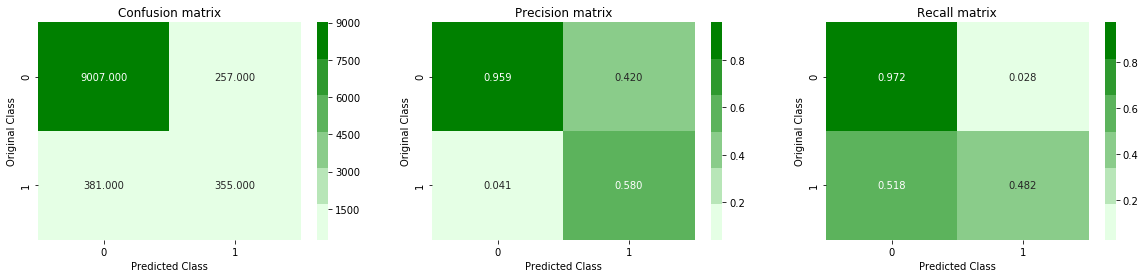

In [36]:
dt_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train.values)

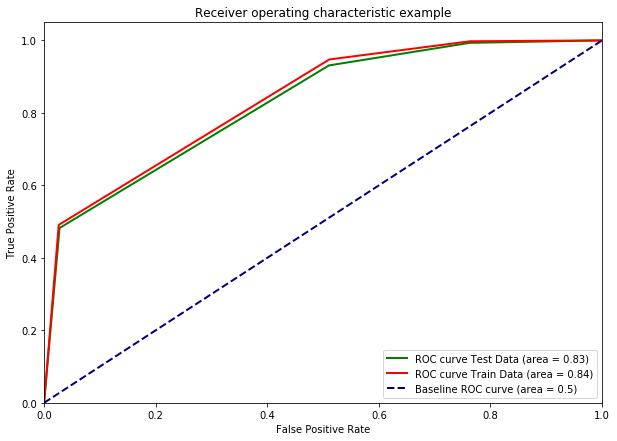

In [37]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

In [40]:
results = pd.DataFrame([['Decision Tree (Balanced) ',0.826,0.923]],
               columns = ['Model', 'Auc_Roc','F1_Score'])
results

Model  Auc_Roc  F1_Score
0  Decision Tree (Balanced)     0.826     0.923

#### 1.2 Random Forest

In [38]:
st=dt.now()
tuned_parameters = {'max_depth':[3,4,5,6,7,8,9,10],
                    'criterion':['gini','entropy'],
                    'min_samples_split':[2,3,5,7,9], 
                    'min_samples_leaf':[1, 10, 25, 50, 75, 100],
                    'n_estimators':[10,20,30,40,50,60,80,100,500,1000],
                    'max_leaf_nodes':[None, 10, 25, 50, 100, 500]}

model = RandomForestClassifier(random_state=rand_state,class_weight='balanced')
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=3, scoring='roc_auc',
                                verbose=5,
                                n_jobs=-1,
                                random_state=rand_state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.2min finished


Time taken to complete random search:  0:07:27.339209


In [39]:
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=9, max_features='auto',
                       max_leaf_nodes=50, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=10,
                       min_samples_split=3, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'n_estimators': 1000, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_leaf_nodes': 50, 'max_depth': 9, 'criterion': 'entropy'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 3

----------------------

Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:02:40.380729


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:01.281369


---------------------
|      F1 Score      |
---------------------

    0.7677


---------------------
|      Accuracy      |
---------------------

    0.7677


---------------------
|      Recall        |
---------------------

    0.7160326086956522


---------------------
|      ROC AUC       |
---------------------

    0.854693630556807


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       0.97      0.77      0.86      9264
           1       0.20      0.72      0.31       736

    accuracy                           0.77     10000
   macro avg       0.59      0.74      0.59     10000
weighted avg       0.91      0.77      0.82     10000



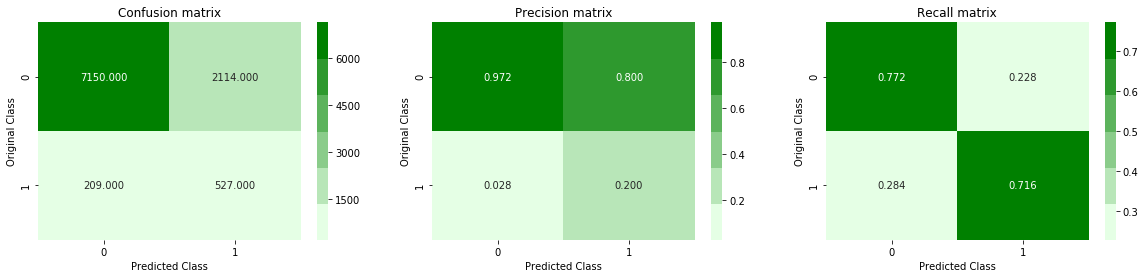

In [40]:
rf_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train.values)

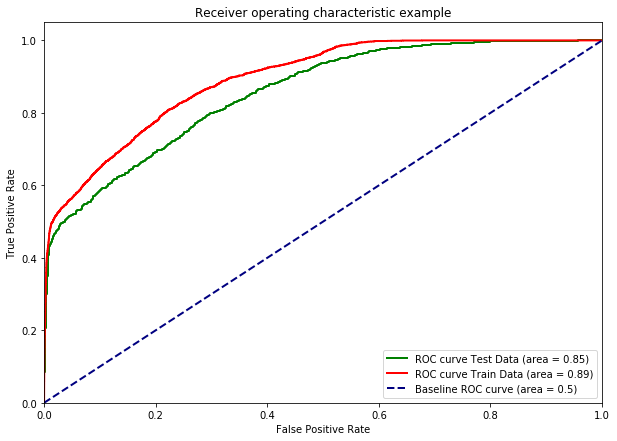

In [41]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

In [41]:
results1 = pd.DataFrame([['Random Forest (Balanced) ',0.854,0.767]],
               columns = ['Model', 'Auc_Roc','F1_Score'])
results=results.append(results1,ignore_index=True)
results

Model  Auc_Roc  F1_Score
0  Decision Tree (Balanced)     0.826     0.923
1  Random Forest (Balanced)     0.854     0.767

#### 1.3 Logistic Regression

In [42]:
st=dt.now()
params = {'C': np.logspace(-4,3,50),
                     'penalty': ['l1','l2'] } #C values used for cross validation

model = LogisticRegression(n_jobs=-1, random_state=rand_state,class_weight='balanced')
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=params, 
                                cv=3, scoring='roc_auc',
                                verbose=2,
                                n_jobs=-1,
                                random_state=rand_state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 33.6min finished


Time taken to complete random search:  0:34:30.337091


In [43]:
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	LogisticRegression(C=0.3727593720314938, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=-1, penalty='l1',
                   random_state=123, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'penalty': 'l1', 'C': 0.3727593720314938}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 3

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.7953565749370936



Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:52.406402


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.041978


---------------------
|      F1 Score      |
---------------------

    0.6805


---------------------
|      Accuracy      |
---------------------

    0.6805


---------------------
|      Recall        |
---------------------

    0.7418478260869565


---------------------
|      ROC AUC       |
---------------------

    0.7916605067770519


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       0.97      0.68      0.80      9264
           1       0.15      0.74      0.25       736

    accuracy                           0.68     10000
   macro avg       0.56      0.71      0.53     10000
weighted avg       0.91      0.68      0.76     10000



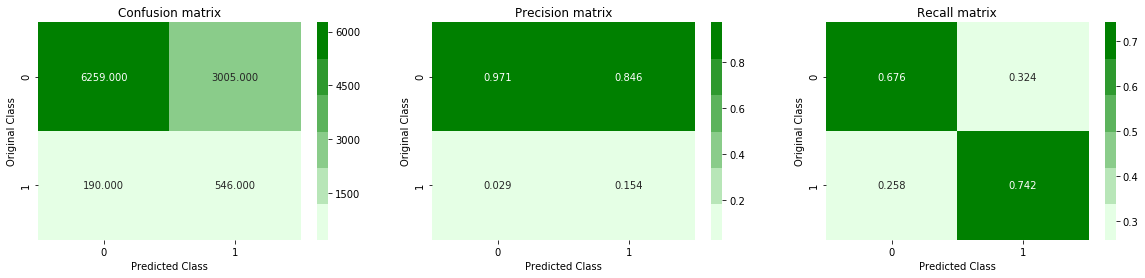

In [44]:
logit_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train.values)

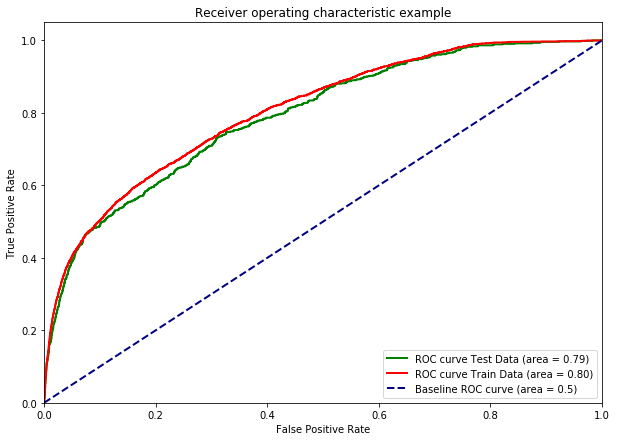

In [45]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

In [42]:
results2 = pd.DataFrame([['Logistic Regression (Balanced) ',0.791,0.680]],
               columns = ['Model', 'Auc_Roc','F1_Score'])
results=results.append(results2,ignore_index=True)
results

Model  Auc_Roc  F1_Score
0        Decision Tree (Balanced)     0.826     0.923
1        Random Forest (Balanced)     0.854     0.767
2  Logistic Regression (Balanced)     0.791     0.680

### 2. Random Upsampling

In [6]:
# Loading the saved file for appetency
df_train_upselling=pd.read_csv('df_train_upselling.csv')

In [7]:
X=df_train_upselling
y=df_train_upselling['upselling']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=rand_state)

print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in train data:', y_train.shape[0])
print('Number of data points in test data:', y_test.shape[0])

Number of data points in train data: 40000
Number of data points in test data: 10000
Number of data points in train data: 40000
Number of data points in test data: 10000


In [9]:
X_train.upselling.value_counts()

0    37054
1     2946
Name: upselling, dtype: int64

In [10]:
# Separate majority and minority classes
df_majority = X_train[X_train.upselling==0]
df_minority = X_train[X_train.upselling==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=37054,    # to match majority class
                                 random_state=rand_state) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.upselling.value_counts()

1    37054
0    37054
Name: upselling, dtype: int64

In [11]:
X_train=df_upsampled.drop("upselling", axis=1)
y_train =df_upsampled['upselling']
X_test=X_test.drop("upselling", axis=1)
y_test=y_test

In [12]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (74108, 77)
Number transactions y_train dataset:  (74108,)
Number transactions X_test dataset:  (10000, 77)
Number transactions y_test dataset:  (10000,)


#### 2.1 Decision tree

In [52]:
st=dt.now()

params = {'max_depth': np.arange(2,30,2),
                    'criterion': ['gini','entropy'],
                    'min_samples_split': np.arange(0.1,1.0,0.1),
                    'min_samples_leaf' : np.arange(1,10,1),
                    'min_weight_fraction_leaf' : [0.0,0.1,0.2,0.3,0.4]} 

model = DecisionTreeClassifier(random_state=rand_state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=params, 
                                cv=3, scoring='roc_auc',
                                verbose=1,
                                n_jobs=-1,
                                random_state=rand_state)

rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.1s finished


Time taken to complete random search:  0:00:19.995006


In [53]:
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=22,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=0.5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'min_weight_fraction_leaf': 0.0, 'min_samples_split': 0.5, 'min_samples_leaf': 2, 'max_depth': 22, 'criterion': 'entropy'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 3

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of bes

Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:01.671042


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.015992


---------------------
|      F1 Score      |
---------------------

    0.9362


---------------------
|      Accuracy      |
---------------------

    0.9362


---------------------
|      Recall        |
---------------------

    0.48233695652173914


---------------------
|      ROC AUC       |
---------------------

    0.8269170749793497


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      9264
           1       0.58      0.48      0.53       736

    accuracy                           0.94     10000
   macro avg       0.77      0.73      0.75     10000
weighted avg       0.93      0.94      0.93     10000



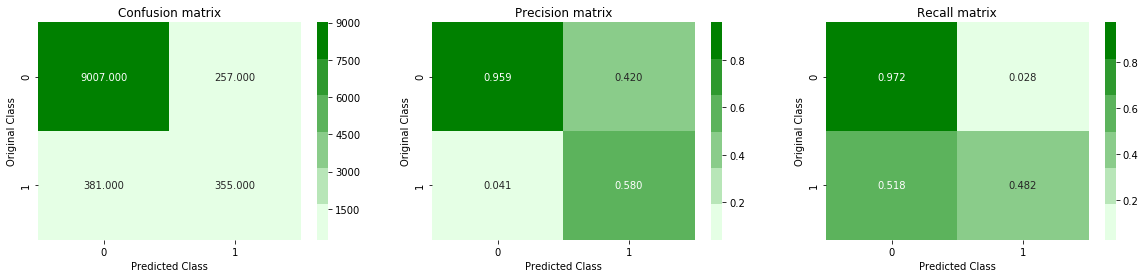

In [54]:
dt_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train.values)

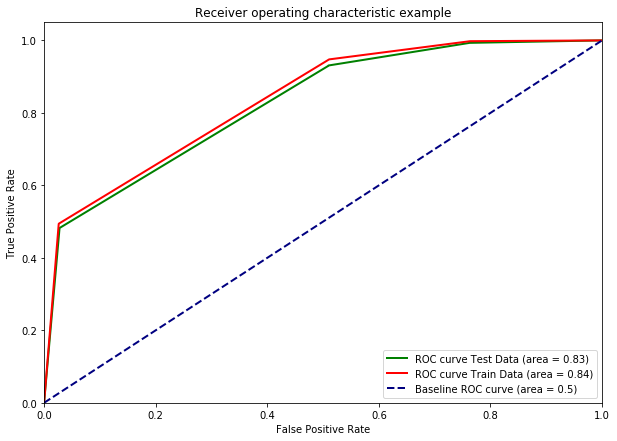

In [55]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

In [43]:
results3 = pd.DataFrame([['Decision Tree (upsampled) ',0.826,0.936]],
               columns = ['Model', 'Auc_Roc','F1_Score'])
results=results.append(results3,ignore_index=True)
results

Model  Auc_Roc  F1_Score
0        Decision Tree (Balanced)     0.826     0.923
1        Random Forest (Balanced)     0.854     0.767
2  Logistic Regression (Balanced)     0.791     0.680
3       Decision Tree (upsampled)     0.826     0.936

#### 2.2 Random Forest

In [56]:
st=dt.now()
tuned_parameters = {'max_depth':[3,4,5,6,7,8,9,10],
                    'criterion':['gini','entropy'],
                    'min_samples_split':[2,3,5,7,9], 
                    'min_samples_leaf':[1, 10, 25, 50, 75, 100],
                    'n_estimators':[10,20,30,40,50,60,80,100,500,1000],
                    'max_leaf_nodes':[None, 10, 25, 50, 100, 500]}

model = RandomForestClassifier(random_state=rand_state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=tuned_parameters, 
                                cv=3, scoring='roc_auc',
                                verbose=5,
                                n_jobs=-1,
                                random_state=rand_state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.1min finished


Time taken to complete random search:  0:06:28.046494


In [57]:
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=500,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'n_estimators': 80, 'min_samples_split': 7, 'min_samples_leaf': 25, 'max_leaf_nodes': 500, 'max_depth': 10, 'criterion': 'entropy'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 3

--------------------------
|

Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:22.093344


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.149915


---------------------
|      F1 Score      |
---------------------

    0.8324


---------------------
|      Accuracy      |
---------------------

    0.8324


---------------------
|      Recall        |
---------------------

    0.6345108695652174


---------------------
|      ROC AUC       |
---------------------

    0.8574858205207629


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       0.97      0.85      0.90      9264
           1       0.25      0.63      0.36       736

    accuracy                           0.83     10000
   macro avg       0.61      0.74      0.63     10000
weighted avg       0.91      0.83      0.86     10000



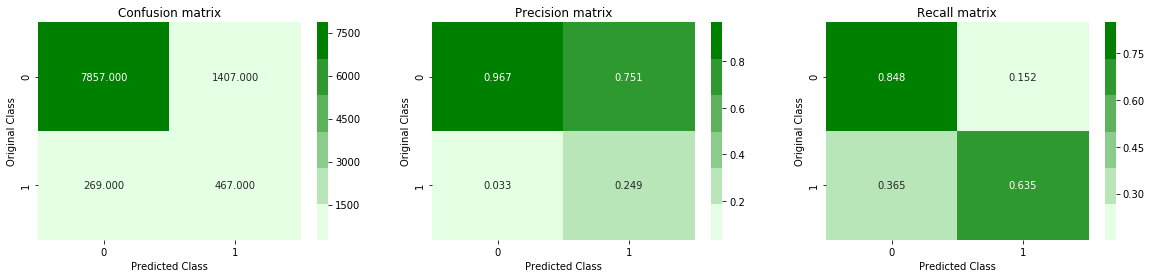

In [58]:
rf_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train)

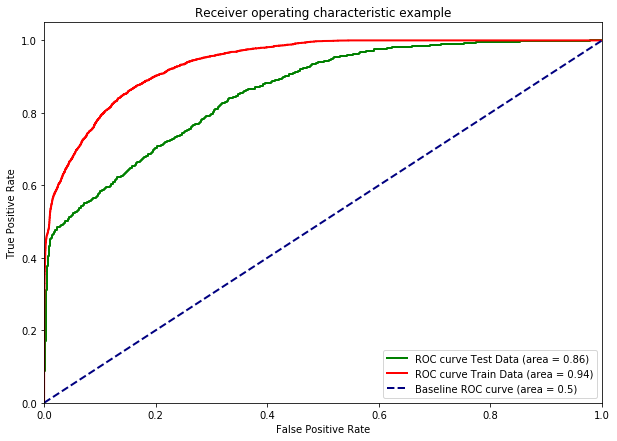

In [59]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

In [44]:
results4 = pd.DataFrame([['Random Forest (upsampled) ',0.857,0.832]],
               columns = ['Model', 'Auc_Roc','F1_Score'])
results=results.append(results4,ignore_index=True)
results

Model  Auc_Roc  F1_Score
0        Decision Tree (Balanced)     0.826     0.923
1        Random Forest (Balanced)     0.854     0.767
2  Logistic Regression (Balanced)     0.791     0.680
3       Decision Tree (upsampled)     0.826     0.936
4       Random Forest (upsampled)     0.857     0.832

#### 2.3 Logistic Regression

In [60]:
st=dt.now()
params = {'C': np.logspace(-4,3,50),
                     'penalty': ['l1','l2'] } #C values used for cross validation

model = LogisticRegression(n_jobs=-1, random_state=rand_state)
rsearch_cv = RandomizedSearchCV(estimator=model, 
                                param_distributions=params, 
                                cv=3, scoring='roc_auc',
                                verbose=2,
                                n_jobs=-1,
                                random_state=rand_state)
rsearch_cv.fit(X_train, y_train)

print("Time taken to complete random search: ",dt.now()-st)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.8min finished


Time taken to complete random search:  0:10:19.763521


In [61]:
print_grid_search_attributes(rsearch_cv)

--------------------------
|      Best Estimator     |
--------------------------

	LogisticRegression(C=0.3727593720314938, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=-1, penalty='l1',
                   random_state=123, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'penalty': 'l1', 'C': 0.3727593720314938}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 3

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.8039157754664794



Training the model...
Training completed... 
 

Training Time (HH:MM:SS.ms) -- 0:00:32.024258


Predicting test data...
Predicting test data completed... 
 

Testing Time(HH:MM:SS:ms) -- 0:00:00.010993


---------------------
|      F1 Score      |
---------------------

    0.6814


---------------------
|      Accuracy      |
---------------------

    0.6814


---------------------
|      Recall        |
---------------------

    0.7391304347826086


---------------------
|      ROC AUC       |
---------------------

    0.7906568847619585


-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       0.97      0.68      0.80      9264
           1       0.15      0.74      0.25       736

    accuracy                           0.68     10000
   macro avg       0.56      0.71      0.53     10000
weighted avg       0.91      0.68      0.76     10000



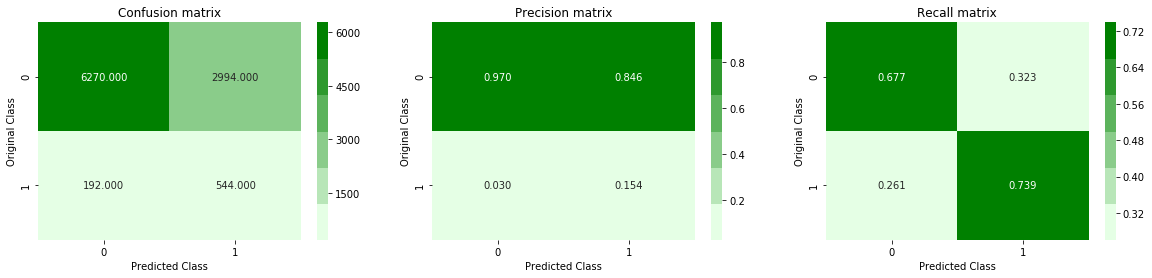

In [62]:
log_reg_grid_results, trained_model =  model_report(rsearch_cv, X_train, y_train, X_test, y_test, class_labels=y_train.values)

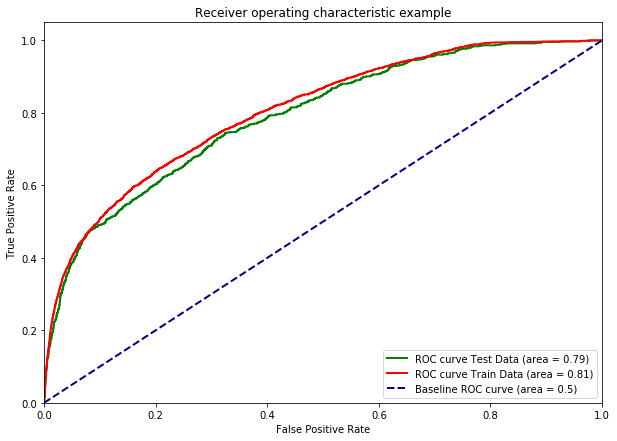

In [63]:
#Calibrate the model
sig_clf = CalibratedClassifierCV(trained_model, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

In [45]:
results5 = pd.DataFrame([['Random Forest (upsampled) ',0.790,0.681]],
               columns = ['Model', 'Auc_Roc','F1_Score'])
results=results.append(results5,ignore_index=True)
results

Model  Auc_Roc  F1_Score
0        Decision Tree (Balanced)     0.826     0.923
1        Random Forest (Balanced)     0.854     0.767
2  Logistic Regression (Balanced)     0.791     0.680
3       Decision Tree (upsampled)     0.826     0.936
4       Random Forest (upsampled)     0.857     0.832
5       Random Forest (upsampled)     0.790     0.681

#### 2.4 ANN 

In [15]:
import keras
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Dropout
from keras import optimizers
from keras.metrics import binary_crossentropy
from keras.utils import to_categorical
from sklearn.metrics import roc_curve

Using TensorFlow backend.


In [13]:
X_train_sc = preprocessing.scale(X_train)
X_test_sc = preprocessing.scale(X_test)

In [16]:
#Initializing parameters
epochs = 20
batch_size = 256
first_layer_input = X_train.shape[1]
optim=optimizers.Adam(lr=0.001)

In [17]:
def build_model():
    model = Sequential()
    model.add(Dense(32,  input_shape=(first_layer_input, ), activation='relu',kernel_initializer='he_uniform'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
    return model

In [18]:
from keras.wrappers.scikit_learn import KerasClassifier
model = build_model()
model.fit(X_train_sc, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Train on 59286 samples, validate on 14822 samples
Epoch 1/20
59286/59286 [==============================] - 3s 47us/step - loss: 0.5710 - acc: 0.6905 - val_loss: 0.7112 - val_acc: 0.5846
Epoch 2/20
59286/59286 [==============================] - 1s 22us/step - loss: 0.4791 - acc: 0.7646 - val_loss: 0.6637 - val_acc: 0.5552
Epoch 3/20
59286/59286 [==============================] - 1s 22us/step - loss: 0.4507 - acc: 0.7799 - val_loss: 0.6698 - val_acc: 0.5629
Epoch 4/20
59286/59286 [==============================] - 1s 20us/step - loss: 0.4333 - acc: 0.7904 - val_loss: 0.5970 - val_acc: 0.6209
Epoch 5/20
59286/59286 [==============================] - 1s 20us/step - loss: 0.4172 - acc: 0.7986 - val_loss: 0.5738 - val_acc: 0.6453
Epoch 6/20
59286/59286 [==============================] - 1s 24us/step - loss: 0.4002 - acc: 0.8095 - val_loss: 0.6086 - val_acc: 0.6326
Epoch 7/20
59286/59286 [==============================] - 1s 21us/step - loss: 0.3875 - acc: 0.8162 - val_loss: 0.5848 - val_acc

In [20]:
# Predicting the Test set results
y_pred = model.predict(X_test_sc)
y_pred = (y_pred > 0.5)


F1 Score = 1.0

Accuracy = 0.7779

Recall = 0.6019021739130435

ROC-AUC = 0.6968923650221521

-------------------------
| Classifiction Report  |
-------------------------
              precision    recall  f1-score   support

           0       0.96      0.79      0.87      9264
           1       0.19      0.60      0.29       736

    accuracy                           0.78     10000
   macro avg       0.57      0.70      0.58     10000
weighted avg       0.90      0.78      0.83     10000



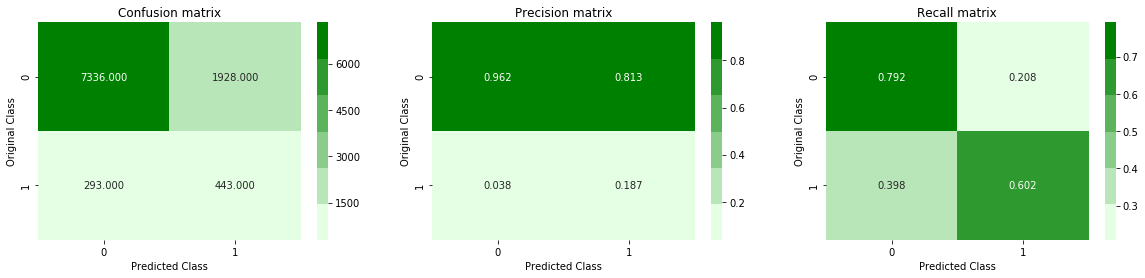

In [21]:
nn_results = dict()

#Compute the F1 score 
f1_score = metrics.f1_score(y_true=y_test, y_pred=y_test, average='micro') #F1 = 2 * (precision * recall) / (precision + recall)
nn_results['F1_Score'] = f1_score
print('\nF1 Score = {}'.format(f1_score))      


#Calculate overall accuracy of the model
accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
nn_results['Accuracy'] = accuracy
print('\nAccuracy = {}'.format(accuracy))

#Calculate overall recall_score of the model
recall = metrics.recall_score(y_true=y_test, y_pred=y_pred)
nn_results['Recall'] = recall
print('\nRecall = {}'.format(recall))

#Calculate overall roc-auc of the model
#Calibrate the model
roc_auc = metrics.roc_auc_score(y_true=y_test, y_score=y_pred)
nn_results['ROC-AUC'] = roc_auc
print('\nROC-AUC = {}\n'.format(roc_auc))   

#Display the classification report having individual class recalls and precision values.
print('-------------------------')
print('| Classifiction Report  |')
print('-------------------------')
classification_report = metrics.classification_report(y_test, y_pred)

#Store report in nn_results
nn_results['Classification_Report'] = classification_report
print(classification_report)

#Add the trained  model to the nn_results
nn_results['Model'] = model

#Plot the confusion matrix curve
plot_confusion_matrix(y_test, y_pred)

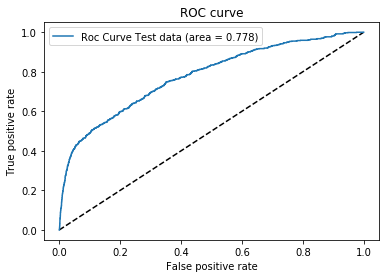

In [22]:
y_pred_keras = model.predict(X_test_sc).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Roc Curve Test data (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [46]:
results6 = pd.DataFrame([['ANN (upsampled) ',0.77,1]],
               columns = ['Model', 'Auc_Roc','F1_Score'])
results=results.append(results6,ignore_index=True)
results

Model  Auc_Roc  F1_Score
0        Decision Tree (Balanced)     0.826     0.923
1        Random Forest (Balanced)     0.854     0.767
2  Logistic Regression (Balanced)     0.791     0.680
3       Decision Tree (upsampled)     0.826     0.936
4       Random Forest (upsampled)     0.857     0.832
5       Random Forest (upsampled)     0.790     0.681
6                 ANN (upsampled)     0.770     1.000

### 2.5 Voting Classifier

In [33]:
estimators=[]
model1 = LogisticRegression(C=0.3727593720314938,  penalty='l1',
                   random_state=123)
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier( criterion='entropy', max_depth=22,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=0.5,
                       min_weight_fraction_leaf=0.0)
estimators.append(('Decision Tree', model2))
model3=RandomForestClassifier(criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=500,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=80)
estimators.append(('rf',model3))

In [34]:
from sklearn.ensemble import VotingClassifier
# create the ensemble model
ensemble = VotingClassifier(estimators,voting='soft')

In [35]:
ensemble.fit(X_train,y_train)

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(C=0.3727593720314938,
                                                 class_weight=None, dual=False,
                                                 fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l1',
                                                 random_state=123,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('Decision Tree',
                              DecisionTreeClassifier(class_weight=None,
                                                     cr...
                                            

In [36]:
y_pred = ensemble.predict(X_test)

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [38]:
res = pd.DataFrame([['Voting Classifier', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
res

Model  Accuracy  Precision    Recall  F1 Score
0  Voting Classifier    0.7957   0.215498  0.672554  0.326409

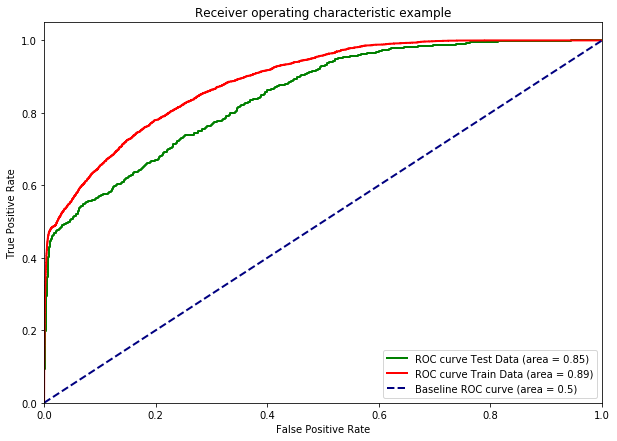

In [39]:
#Calibrate the model
from sklearn.calibration import CalibratedClassifierCV
sig_clf = CalibratedClassifierCV(ensemble, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Plot the ROC curve
plot_roc_curve(sig_clf, X_train, y_train, X_test, y_test)

In [47]:
results7 = pd.DataFrame([['Voting Classifier (upsampled) ',0.85,0.32]],
               columns = ['Model', 'Auc_Roc','F1_Score'])
results=results.append(results7,ignore_index=True)
results

Model  Auc_Roc  F1_Score
0        Decision Tree (Balanced)     0.826     0.923
1        Random Forest (Balanced)     0.854     0.767
2  Logistic Regression (Balanced)     0.791     0.680
3       Decision Tree (upsampled)     0.826     0.936
4       Random Forest (upsampled)     0.857     0.832
5       Random Forest (upsampled)     0.790     0.681
6                 ANN (upsampled)     0.770     1.000
7   Voting Classifier (upsampled)     0.850     0.320

### 3. Model Interpretebility

In [65]:
feature_names=['Unnamed: 0', 'Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24',
       'Var25', 'Var28', 'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var72',
       'Var73', 'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var94',
       'Var109', 'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var126',
       'Var132', 'Var133', 'Var134', 'Var140', 'Var143', 'Var144', 'Var149',
       'Var153', 'Var160', 'Var163', 'Var173', 'Var181', 'Var189', 'Var192',
       'Var193', 'Var194', 'Var195', 'Var196', 'Var197', 'Var198', 'Var199',
       'Var200', 'Var201', 'Var202', 'Var203', 'Var204', 'Var205', 'Var206',
       'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var214', 'Var216',
       'Var217', 'Var218', 'Var219', 'Var220', 'Var221', 'Var222', 'Var223',
       'Var225', 'Var226', 'Var227', 'Var228', 'Var229']
class_names = ['No Upselling','Upselling']

In [66]:
import lime
import lime.lime_tabular
#https://christophm.github.io/interpretable-ml-book/lime.html

In [67]:
# Create our Explainer ,a Tabular Explainer since it is a tabular data
explainer1 = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=feature_names, class_names=class_names, discretize_continuous=True)

In [68]:
# Prediction on A Single Sample
trained_model.predict(np.array(X_test.values[0]).reshape(1,-1))

array([1], dtype=int64)

In [69]:
# Prediction on A Single Sample
trained_model.predict(np.array(X_test.values[1]).reshape(1,-1))

array([0], dtype=int64)

In [70]:
exp1 = explainer1.explain_instance(X_test.iloc[0],trained_model.predict_proba,num_features=10,top_labels=1)

In [71]:
# Show in notebook
exp1.show_in_notebook(show_table=True, show_all=False)

##### Observations:-
##### The random forest model has predicted that the datapoint corresponds to upselling with 95% and the the contributions of  different features can clearly be seen.

In [72]:
exp2 = explainer1.explain_instance(X_test.iloc[4],trained_model.predict_proba,num_features=10,top_labels=1)

In [73]:
# Show in notebook
exp2.show_in_notebook(show_table=True, show_all=False)

##### Observations:-
##### The random forest model has predicted that the datapoint corresponds to no upselling with 58% and the the contributions of  different features can clearly be seen.

### Conclusions:-

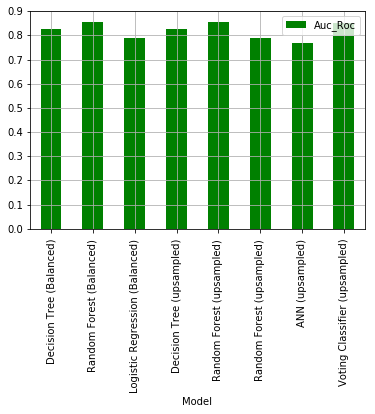

In [48]:
ax = results.plot.bar(x='Model', y='Auc_Roc', rot=90,grid=True,color='green',)